In [2]:
# Uncomment the following line to install the required packages
# if you haven't already done so.

# pip install -r requirements.txt

In [3]:
import concurrent.futures
import json
import operator
from typing import Any, Dict, List, TypedDict, Annotated

from dotenv import load_dotenv
from IPython.display import display, Image, Markdown
from langchain_community.document_loaders import ArxivLoader
from langchain_community.tools import TavilySearchResults
from langchain_groq import ChatGroq
from langgraph.graph import StateGraph, START, END
import gradio as gr
from re import sub

load_dotenv()

/Users/kaushalvachhani/Github-Repos/Multi-Agent-Autonomous-Research-Assistant-using-LangGraph/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


True

In [4]:
model = ChatGroq(model="meta-llama/llama-4-scout-17b-16e-instruct")

class State(TypedDict):
    user_query: str
    metadata: dict
    search_results: Annotated[str, operator.add]
    summary: str
    verification: dict
    formatted_output: str
    messages: List[str]

In [ ]:
def query_understanding_agent(state: State) -> dict:
    user_query = state["user_query"]
    prompt = (
        f"Extract the main topic and subtopics from the following research query:\n\n"
        f"{user_query}\n\n"
        f"Format your answer as JSON with keys: 'main_topic', 'subtopics'."
        f"Limit the number of subtopics to a maximum of 3"
        f"Ensure each subtopic is crafted to comprehensively cover the main topic while also being meaningful and searchable on its own."
        f"Please exclude triple backticks (```) and avoid labeling the output as JSON. Just return the raw JSON data without any formatting or tags."
    )
    response = model.invoke(prompt)
    try:
        metadata = json.loads(response.content)
    except json.JSONDecodeError:
        metadata = {"main_topic": "unknown", "subtopics": []}
    state["metadata"] = metadata
    return state

In [34]:
def search_web_query(query):

    """ Retrieve docs from web search """

    # Search
    tavily_search = TavilySearchResults(max_results=1) # reducing max_result to 1 to avoid rate limit
    search_docs = tavily_search.invoke(query)

     # Format
    formatted_search_docs = "\n\n---\n\n".join(doc["content"] for doc in search_docs)

    return formatted_search_docs

def search_arxiv_query(query):

    """ Retrieve docs from Arxiv """

    # Search
    search_docs = ArxivLoader(query=query,
                                  load_max_docs=1).load()

    # Format (Only pulling the summary of paper avoid rate limit)
    formatted_search_docs = "\n\n---\n\n".join(doc.metadata["Summary"] for doc in search_docs)

    return formatted_search_docs

def process_sub_topic(sub_topic, search_func):
    # Each sub_topic processing is independent
    result = f"\n\n ## {sub_topic}:\n\n" + search_func(sub_topic)
    return result

def search_web(state):
    sub_topics = state['metadata'].get('subtopics', [])
    with concurrent.futures.ThreadPoolExecutor() as executor:
        futures = {executor.submit(process_sub_topic, sub_topic, search_web_query): sub_topic for sub_topic in sub_topics}
        web_results = [future.result() for future in futures]
    return {"search_results": "".join(web_results)}

def search_arxiv(state):
    sub_topics = state['metadata'].get('subtopics', [])
    with concurrent.futures.ThreadPoolExecutor() as executor:
        futures = {executor.submit(process_sub_topic, sub_topic, search_arxiv_query): sub_topic for sub_topic in sub_topics}
        arxiv_results = [future.result() for future in futures]
    return {"search_results": "".join(arxiv_results)}


In [35]:
def summarization_agent(state: State) -> dict:
    search_results = state.get("search_results", "")
    verification = state.get("verification", {})
    notes = verification.get("notes", "")
    user_query = state["user_query"]
    previous_summary = state.get("summary", "")

    prompt = (
    f"Using the following research paper context, provide a very detailed analysis in response to the user's question with appropriate summary title.\n\n"
    f"Context:\n{search_results}\n\n"
    )

    if notes.strip():
        prompt += (
        f"Here is the previously generated summary to reflect upon:\n{previous_summary}\n\n"
        f"Refer to the improvement guidelines below based on your previous responses:\n{notes}\n\n"
      )

    prompt += f"User Question:\n{user_query}"


    response = model.invoke(prompt)

    summary = response.content
    state["summary"] = summary
    return state

In [36]:
def fact_verification_agent(state: State) -> dict:
    summary = state.get("summary", "")
    prompt = (
        f"Verify the factual correctness of the following summary. "
        f"List any potential inaccuracies:\n\n"
        f"{summary}\n\n"
        f"Output your answer as JSON with keys 'verified' (True/False) and 'notes' (String)."
        f"Please exclude triple backticks (```) and avoid labeling the output as JSON. Just return the raw JSON data without any formatting or tags."

    )

    response = model.invoke(prompt)
    try:
        verification = json.loads(response.content)
    except json.JSONDecodeError:
        verification = {"verified": True, "notes": "No issues detected."}
    state["verification"] = verification
    return state

In [ ]:
def verification_critique_router(state: State) -> str:
    verification = state.get("verification", {})

    # Determine next step based on verification status and critique notes
    is_verified = verification.get("verified", True)
    notes = verification.get("notes", "").strip()

    if not is_verified or "No issues detected" not in notes:
        return "summarization"  # Node to handle revisions based on critique
    else:
        return "formatting_export"  # Proceed to formatting and export

In [38]:
def formatting_export_agent(state: State) -> dict:
    summary = state.get("summary", "")
    
    prompt = (
    f"Please reformat the following summary into well-structured Markdown. "
    f"Ensure the output is valid Markdown that can be rendered using display(Markdown(...)).\n\n"
    f"{summary}\n\n"
    )

    response = model.invoke(prompt)
    state["formatted_output"] = response.content
    return state

In [46]:
def build_workflow():
    # Initial state with a user query
    # Define the initial state with required keys

    workflow = StateGraph(State)

    # Add nodes
    workflow.add_node("query_understanding", query_understanding_agent)
    workflow.add_node("search_web", search_web)
    workflow.add_node("search_arxiv", search_arxiv)
    workflow.add_node("summarization", summarization_agent)
    workflow.add_node("fact_verification", fact_verification_agent)
    workflow.add_node("formatting_export", formatting_export_agent)

    # Define edges for parallel execution
    workflow.add_edge(START, "query_understanding")
    workflow.add_edge("query_understanding", "search_web")
    workflow.add_edge("query_understanding", "search_arxiv")
    workflow.add_edge("search_web", "summarization")
    workflow.add_edge("search_arxiv", "summarization")
    workflow.add_edge("summarization", "fact_verification")
    workflow.add_conditional_edges(
      source="fact_verification",
      path=verification_critique_router,
      path_map={
          "summarization": "summarization",
          "formatting_export": "formatting_export"
      }
    )
    workflow.add_edge("formatting_export", END)

    return workflow


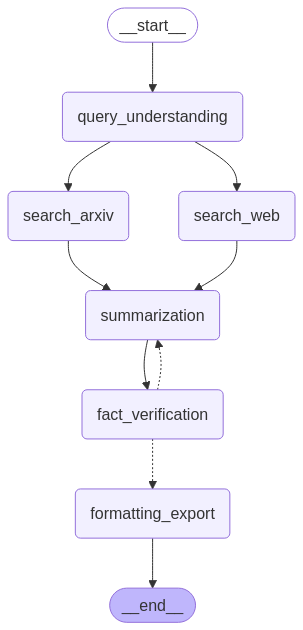

In [ ]:
if __name__ == "__main__":
    # Example of a initial state
    initial_state: State = {
        "user_query": "Future of LLMOPs",
        "metadata": {},          # To be filled by Query Understanding Agent
        "search_results": "",    # To be filled by Search & Retrieval Agent
        "summary": "",           # To be filled by Summarization Agent
        "verification": {},      # To be filled by Fact Verification Agent
        "formatted_output": "",  # To be filled by Formatting/Export Agent
        "messages": []           # Optionally, track conversation history
    }


    # Build and execute the workflow
    workflow = build_workflow()
    graph = workflow.compile()
    display(Image(graph.get_graph().draw_mermaid_png()))
    results = graph.invoke(initial_state)

In [41]:
display(Markdown(results["formatted_output"]))

# The Future of Large Language Models in Operations (LLMOPs): Trends, Challenges, and Opportunities

The rapid evolution of Large Language Models (LLMs) is transforming the landscape of software engineering, operations, and artificial intelligence. As we look ahead to the future of LLMOPs, it is essential to analyze the current trends, challenges, and opportunities in this field.

## Current Trends

The following are the current trends in LLMOPs:

1. **Increased Adoption**: LLMs are becoming increasingly popular in software engineering, with applications in software design, automated programming, and maintenance.
2. **Advancements in Deep Learning**: The development of more sophisticated deep learning algorithms and massive amounts of data are driving the improvement of LLMs.
3. **Growing Focus on Efficiency and Sustainability**: The field is shifting towards more efficient and sustainable LLMs, with a critical focus on performance improvements.

## Challenges

The following are the challenges in LLMOPs:

1. **Evaluating Pragmatic Abilities**: Assessing the ability of LLMs to handle pragmatic phenomena, such as implicatures and references, remains a significant challenge.
2. **Software Requirement & Design**: LLMs face challenges in understanding software requirements and design, which can lead to errors and inefficiencies.
3. **Coding Assistance and Testing**: LLMs require improvement in coding assistance and testing, including code generation, review, and maintenance.
4. **Software Vulnerability Management**: LLMs must be able to identify and manage software vulnerabilities effectively.
5. **Data, Training, and Evaluation**: The development of comprehensive and targeted benchmarks for evaluating LLMs is crucial.

## Opportunities

The following are the opportunities in LLMOPs:

1. **Improved Software Development**: LLMs have the potential to significantly reduce human effort in software development activities, such as coding, testing, and maintenance.
2. **Enhanced Decision-Making**: LLMs can assist in decision-making by providing insights and recommendations based on large datasets.
3. **Increased Efficiency**: LLMs can automate routine tasks, freeing up human resources for more complex and creative tasks.
4. **Better Software Quality**: LLMs can improve software quality by detecting errors and vulnerabilities early in the development process.

## Emerging Trends

The following are the emerging trends in LLMOPs:

1. **Integration with Other AI Technologies**: LLMs will likely be integrated with other AI technologies, such as computer vision and natural language processing.
2. **Explainability and Transparency**: There will be a growing need for explainable and transparent LLMs, enabling users to understand the decision-making process.
3. **Edge AI**: LLMs will be deployed on edge devices, enabling real-time processing and reducing latency.

## Future Directions

The following are the future directions in LLMOPs:

1. **Developing More Comprehensive Benchmarks**: Creating more comprehensive and targeted benchmarks for evaluating LLMs is essential for advancing the field.
2. **Improving Pragmatic Abilities**: Developing LLMs with improved pragmatic abilities will enable more nuanced and context-aware NLP models.
3. **Addressing Challenges and Risks**: Addressing the challenges and risks associated with LLMs, such as bias, fairness, and security, is crucial for widespread adoption.

## Conclusion

In conclusion, the future of LLMOPs holds significant promise, with opportunities for improved software development, enhanced decision-making, and increased efficiency. However, addressing the challenges and risks associated with LLMs is essential for realizing their full potential. As the field continues to evolve, we can expect to see major breakthroughs in technical innovations, market dynamics, and emerging trends.

In [51]:
import gradio as gr

def display_markdown(text):
    initial_state: State = {
        "user_query": text,
        "metadata": {},          # To be filled by Query Understanding Agent
        "search_results": "",    # To be filled by Search & Retrieval Agent
        "summary": "",           # To be filled by Summarization Agent
        "verification": {},      # To be filled by Fact Verification Agent
        "formatted_output": "",  # To be filled by Formatting/Export Agent
        "messages": []           # Optionally, track conversation history
    }
    return graph.invoke(initial_state)["formatted_output"]  # Markdown will render formatting automatically

with gr.Blocks() as demo:
    gr.Markdown("# Multi-agent Research Assistant")
    
    with gr.Row():
        with gr.Column(scale=1):
            input_text = gr.Textbox(
                label="Enter a research query", 
                placeholder="e.g. 'llm security risks'", 
                lines=2
            )
            submit_btn = gr.Button("Submit")
        with gr.Column(scale=3):
            output_md = gr.Markdown()

    submit_btn.click(display_markdown, inputs=input_text, outputs=output_md)

demo.launch()

* Running on local URL:  http://127.0.0.1:7865

To create a public link, set `share=True` in `launch()`.
